In [1]:
import warnings; 
warnings.simplefilter('ignore')

In [22]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

In [69]:
df = pd.read_csv('AirPassengers.csv')
df.head(3)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


### Exploring the data

In [70]:
df.dtypes

Month          object
#Passengers     int64
dtype: object

In [71]:
#converting to datetime format
df['Month'] = pd.to_datetime(df['Month'])

In [72]:
df.dtypes

Month          datetime64[ns]
#Passengers             int64
dtype: object

In [73]:
df.set_index('Month',inplace=True)

In [74]:
df.head(3)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132


In [75]:
#renaming the columns
df.columns = ['Passengers']

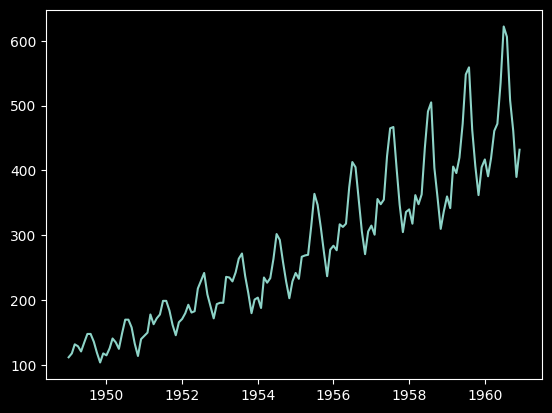

In [76]:
plt.plot(df['Passengers'])

There is an upward trend and seasonality

In [77]:
#Check the staionarity using DickeyFuller Test

from statsmodels.tsa.stattools import adfuller
adf,pvalue,usedlag_,nobs_,critical_values_,icbest_ = adfuller(df)
print(pvalue)

0.991880243437641


Since p value is >.5 the datset is not stationary. Hence will have to use SARIMA and not ARIMA

In [78]:
#Trying tom capture trend wrt year and month
df['Year'] = [d.year for d in df.index]
df['Month'] = [d.strftime('%b') for d in df.index]


In [79]:
df.index.names = ['Date']

In [80]:
df.head(3)

,Passengers,Year,Month
Date,,,
1949-01-01,112,1949,Jan
1949-02-01,118,1949,Feb
1949-03-01,132,1949,Mar


<Axes: xlabel='Year', ylabel='Passengers'>

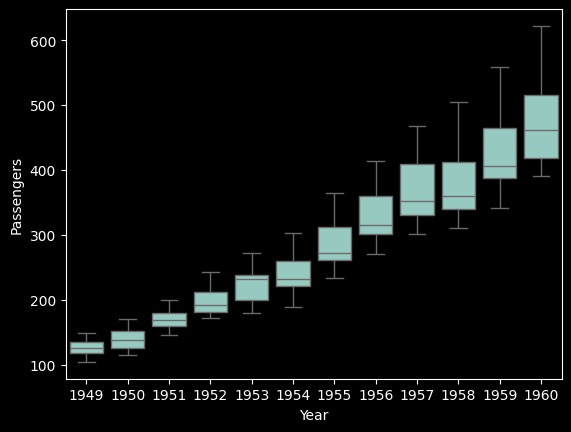

In [82]:
#Plot monthly and yearly values as boxplot
sns.boxplot(x='Year',y='Passengers',data=df)

Clearly there is an upward trend yearwise

<Axes: xlabel='Month', ylabel='Passengers'>

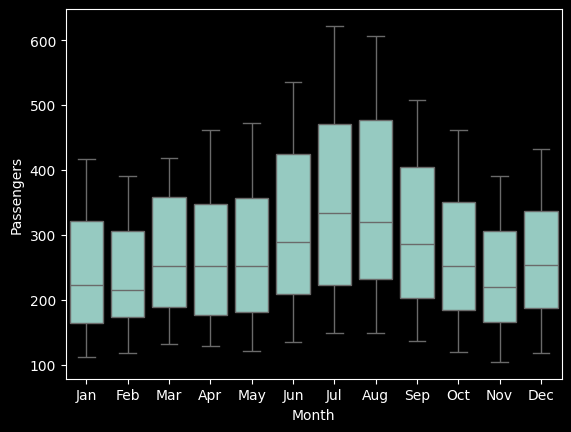

In [83]:
sns.boxplot(x='Month',y='Passengers',data=df)

There is a seasonality. Specifically the no of passengers go up in the month of Jun and July 

In [99]:
#Extract and plot trend, seasonal and residuals by decompsing the original data
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(df['Passengers'], model ='additive')


In [85]:
#Additive time series:
#Value = Base Level + Trend + Seasonality + Error
#Multiplicative Time Series:
#Value = Base Level x Trend x Seasonality x Error

In [91]:
#Extract the decomposed info
trend = decomposed.trend
seasonal = decomposed.seasonal #Cyclic behavior may not be seasonal!
residual = decomposed.resid

In [96]:
seasonal

Date
1949-01-01   -24.748737
1949-02-01   -36.188131
1949-03-01    -2.241162
1949-04-01    -8.036616
1949-05-01    -4.506313
                ...    
1960-08-01    62.823232
1960-09-01    16.520202
1960-10-01   -20.642677
1960-11-01   -53.593434
1960-12-01   -28.619949
Name: seasonal, Length: 144, dtype: float64

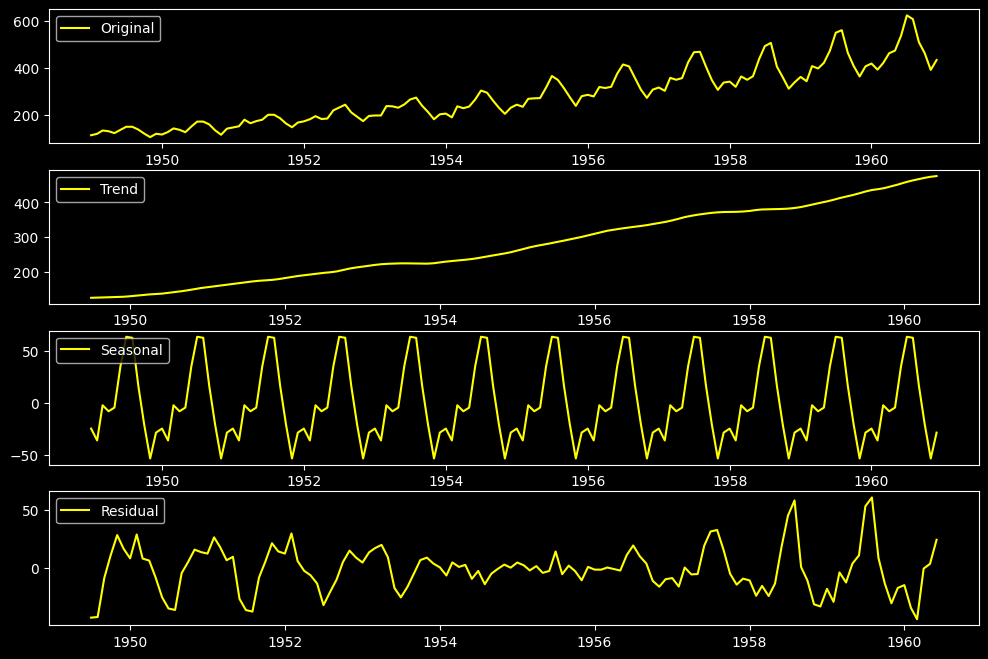

In [94]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df['Passengers'], label='Original', color='yellow')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='yellow')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='yellow')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='yellow')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#AUTOCORRELATION
#Autocorrelation is simply the correlation of a series with its own lags.
# Plot lag on x axis and correlation on y axis
#Any correlation above confidence lnes are statistically significant.

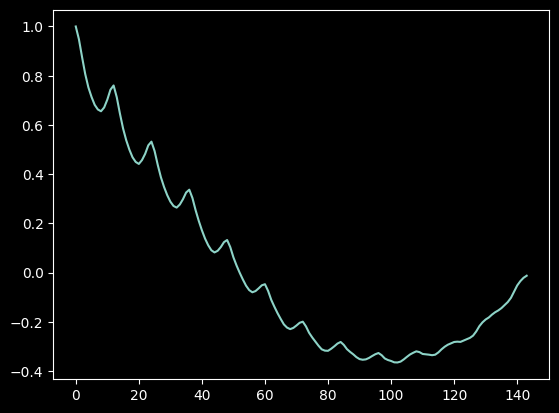

In [100]:
from statsmodels.tsa.stattools import acf

acf_144 = acf(df.Passengers, nlags=144)
plt.plot(acf_144)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

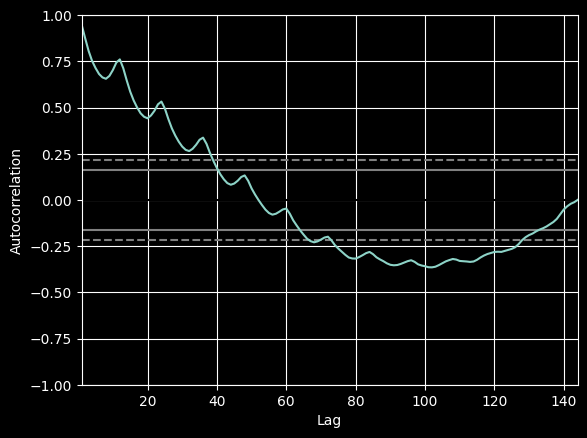

In [101]:
#Obtain the same but with single line and more info...
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df.Passengers) 

Horizontal bands indicate 95% and 99% (dashed) confidence bands. A strong positive correlation for lags below 40 (months)

### Finding the best model using Autoarima

We can go through the exercise of making the data stationary and performing ARIMA Or let auto_arima provide the best model (e.g. SARIMA) and parameters. 
Auto arima suggests best model and parameters based on AIC metric (relative quality of statistical models)

In [104]:
from pmdarima.arima import auto_arima
#Autoarima gives us the best model suited for the data
# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components

In [105]:
arima_model = auto_arima(df['Passengers'], start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50)     

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.22 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.28 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1020.582, Time=0.52 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.67 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.27 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.70 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.20 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.36 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.48 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.29 sec
 ARIMA(0,1,1)(1,1,0)[12]     

In [107]:
print(arima_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Sat, 17 Feb 2024   AIC                           1019.178
Time:                                     16:06:37   BIC                           1030.679
Sample:                                 01-01-1949   HQIC                          1023.851
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      

Autoarima suggesting Model: SARIMAX(0, 1, 1)x(2, 1, [], 12)

In [111]:
#Split the data into train and test
size = int(len(df)*.66)
X_train,X_test = df[0:size],df[size:len(df)]

In [112]:
len(X_train),len(X_test)

(95, 49)

In [141]:
X_train

,Passengers,Year,Month
Date,,,
1949-01-01,112,1949,Jan
1949-02-01,118,1949,Feb
1949-03-01,132,1949,Mar
1949-04-01,129,1949,Apr
1949-05-01,121,1949,May
...,...,...,...
1956-07-01,413,1956,Jul
1956-08-01,405,1956,Aug
1956-09-01,355,1956,Sep


#### Model Training and prediction using SARIMAX

In [113]:
#Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 

In [114]:
model = SARIMAX(X_train['Passengers'],  
                order = (0, 1, 1),  
                seasonal_order =(2, 1, 1, 12)) 
  
result = model.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                   95
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -300.269
Date:                            Sat, 17 Feb 2024   AIC                            610.538
Time:                                    16:33:16   BIC                            622.572
Sample:                                01-01-1949   HQIC                           615.370
                                     - 11-01-1956                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3198      0.102     -3.149      0.002      -0.519      -0.121
ar.S.L12       0.6846      0.661      1.036      0.300      -0.611       1.980
ar.S.L24       0.3140      0.133      2.359      0.018       0.053       0.575
ma.S.L12      -0.9795      5.464     -0.179      0.858     -11.689       9.730
sigma2        78.7761    378.491      0.208      0.835    -663.053     820.605
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.56
Prob(Q):                              0.95   Prob(JB):                         0.28
Heteroskedasticity (H):               1.69   Skew:                             0.42
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [117]:
#Train prediction
start_index = 0
end_index =len(X_train)-1
train_prediction = result.predict(start_index, end_index)
train_prediction,X_train


(1949-01-01      0.000000
 1949-02-01    111.998300
 1949-03-01    117.999818
 1949-04-01    131.999575
 1949-05-01    129.000091
                  ...    
 1956-07-01    419.542397
 1956-08-01    398.685486
 1956-09-01    365.422731
 1956-10-01    320.671222
 1956-11-01    274.817502
 Freq: MS, Name: predicted_mean, Length: 95, dtype: float64,
             Passengers  Year Month
 Date                              
 1949-01-01         112  1949   Jan
 1949-02-01         118  1949   Feb
 1949-03-01         132  1949   Mar
 1949-04-01         129  1949   Apr
 1949-05-01         121  1949   May
 ...                ...   ...   ...
 1956-07-01         413  1956   Jul
 1956-08-01         405  1956   Aug
 1956-09-01         355  1956   Sep
 1956-10-01         306  1956   Oct
 1956-11-01         271  1956   Nov
 
 [95 rows x 3 columns])

Train predictions are almost accurate

In [120]:
#Test prediction
start_index = len(X_train)
end_index =len(df)-1
prediction = result.predict(start_index, end_index).rename('Predicted passengers')
prediction

1956-12-01    311.109986
1957-01-01    320.260658
1957-02-01    310.942675
1957-03-01    351.853915
1957-04-01    349.877332
1957-05-01    355.059001
1957-06-01    411.879720
1957-07-01    457.076481
1957-08-01    445.071349
1957-09-01    395.817291
1957-10-01    347.099123
1957-11-01    309.218867
1957-12-01    352.317845
1958-01-01    361.427654
1958-02-01    351.150667
1958-03-01    394.569733
1958-04-01    392.094513
1958-05-01    398.656530
1958-06-01    459.493062
1958-07-01    505.792463
1958-08-01    493.871179
1958-09-01    440.417941
1958-10-01    388.438813
1958-11-01    349.214598
1958-12-01    394.080508
1959-01-01    404.151627
1959-02-01    392.490236
1959-03-01    437.912388
1959-04-01    435.731118
1959-05-01    443.295220
1959-06-01    507.138846
1959-07-01    556.138895
1959-08-01    543.017438
1959-09-01    486.923485
1959-10-01    432.800260
1959-11-01    391.751535
1959-12-01    438.765681
1960-01-01    449.482123
1960-02-01    436.571792
1960-03-01    484.152778


<Axes: xlabel='Date'>

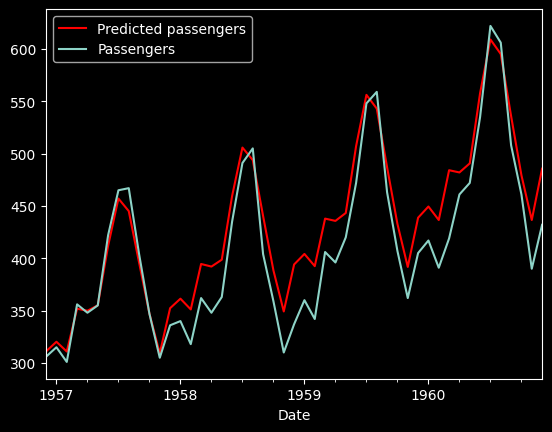

In [122]:
#plot predictions and test results
prediction.plot(legend =True,color = 'red')
X_test['Passengers'].plot(legend =True)

Before predicting the future, its better to check how prediction is for test data. If test data prediction is good, the model can be used for predicting the future trends. In the current scenario, the predictions are not so bad 

In [125]:
import math
from sklearn.metrics import mean_squared_error

In [132]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(X_train['Passengers'], train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(X_test['Passengers'], prediction))
print('Test Score: %.2f RMSE' % (testScore))



Train Score: 16.14 RMSE
Test Score: 29.46 RMSE


RMSE scores are pretty low for test set which implies the model prediction is good

In [133]:
from sklearn.metrics import r2_score
score = r2_score(X_test['Passengers'], prediction)
print("R2 score is: ", score)

R2 score is:  0.8586666837234596


R2 score is pretty high which again indicates the good predcition performance of the model

In [136]:
#Forecast for 3 years

forecast = result.predict(start = len(df),
                         end = (len(df)-1) +3*12,
                         typ = 'levels').rename('Forecast')

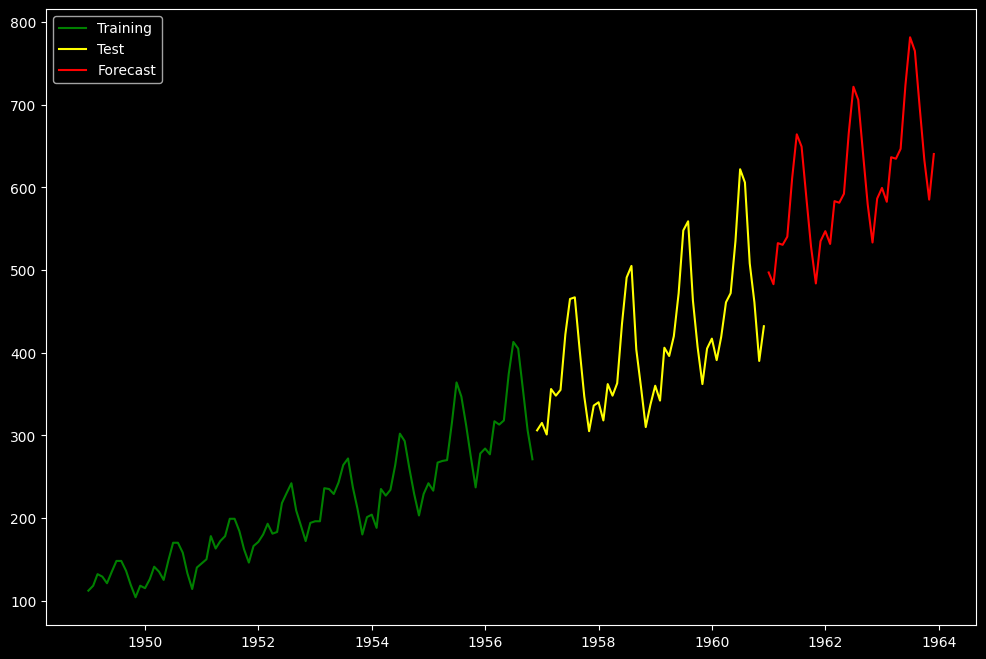

In [139]:
plt.figure(figsize=(12,8))
plt.plot(X_train['Passengers'], label='Training', color='green')
plt.plot(X_test['Passengers'], label='Test', color='yellow')
plt.plot(forecast, label='Forecast', color='red')
plt.legend(loc='upper left')
plt.show()